## Задача понижения размерности данных

Что такое изображение?

![img](https://mymodernmet.com/wp/wp-content/uploads/2017/08/monovision-awards-bw-series-of-the-year-2017-02.jpg)

Формально, просто набор чисел, например, картинка сверху - это матрица 500х750:

In [2]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import requests
from io import BytesIO

url = 'https://mymodernmet.com/wp/wp-content/uploads/2017/08/monovision-awards-bw-series-of-the-year-2017-02.jpg'

response = requests.get(url)
img = Image.open(BytesIO(response.content)).convert('L')
print(np.array(img).shape)
np.array(img)

(500, 750)


array([[145, 145, 144, ..., 142, 143, 144],
       [146, 146, 146, ..., 141, 143, 144],
       [146, 147, 146, ..., 140, 142, 143],
       ...,
       [114, 111, 120, ...,  78,  69,  56],
       [ 75,  83, 104, ...,  53,  51,  64],
       [ 63,  82, 108, ..., 101,  95,  94]], dtype=uint8)

Что если взять случайную точку в пространстве 500*750? Будет ли это какое-то осмысленное изображение? Проверим

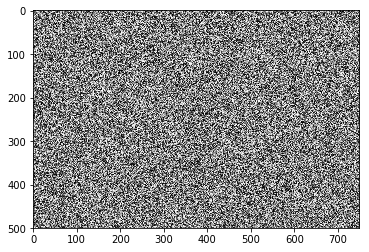

In [3]:
sample_img = np.random.choice(np.arange(256), size=500*750).reshape(500, 750)
plt.imshow(sample_img, cmap='gray')
plt.show()

Вероятно, что осмысленные изображение занимают лишь небольшую долю среди всевозможных числовых матриц? Как описать это подмножество (хотя бы его часть)?

Будем тренироваться строить описание на основе датасете MNIST:

In [26]:
from sklearn.datasets import load_digits
digits = load_digits()
digits.data.shape

(1797, 64)

У меня ругается программа на код, который у Вас в примере, поэтому пришлось писать по-другому, но тут получается шакальное качество, из-за того что итоговый размер картинки не делится на 28 на 28, самое лучшее это 8 на 8.

In [82]:
images = digits.data.reshape(-1, 8, 8)

In [83]:
digits.data

array([[ 0.,  0.,  5., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ..., 10.,  0.,  0.],
       [ 0.,  0.,  0., ..., 16.,  9.,  0.],
       ...,
       [ 0.,  0.,  1., ...,  6.,  0.,  0.],
       [ 0.,  0.,  2., ..., 12.,  0.,  0.],
       [ 0.,  0., 10., ..., 12.,  1.,  0.]])

Пример картинки из датасета:

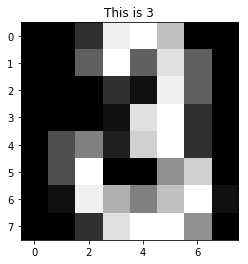

In [84]:
i = 985
plt.imshow(images[i], cmap='gray')
plt.title('This is {}'.format(digits.target[i]))
plt.show()

Воспользуемся моделью PCA:

![img](https://i.stack.imgur.com/G7Gkv.png)

Намопним, PCA ищет подпространство меньшей (но заданной) размерности, проекция на которое максимизирует дисперсию или, что то же самое, минимизирует суммарную ошибку:

![img](http://alexhwilliams.info/itsneuronalblog/img/pca/pca_two_views.png)

Детальное изложение с формулами здесь https://www.csd.uwo.ca/~oveksler/Courses/CS434a_541a/Lecture7.pdf

Пример применение модели PCA (что здесь происходит?):

In [142]:
from sklearn.decomposition import PCA

pca = PCA(n_components=50)

X_transformed = pca.fit_transform(digits.data.astype(float))
X_transformed.shape

(1797, 50)

Дисперсии вдоль главных компонент:

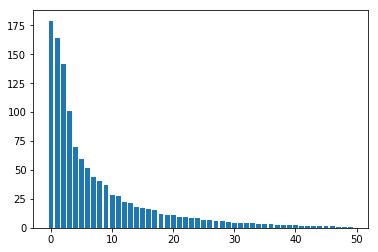

In [143]:
plt.bar(np.arange(50), pca.explained_variance_)
plt.show()

А вот как распределен датасет MNIST в пространстве первых двух главных компонент (разные цвета означают разные цифры на картинках):

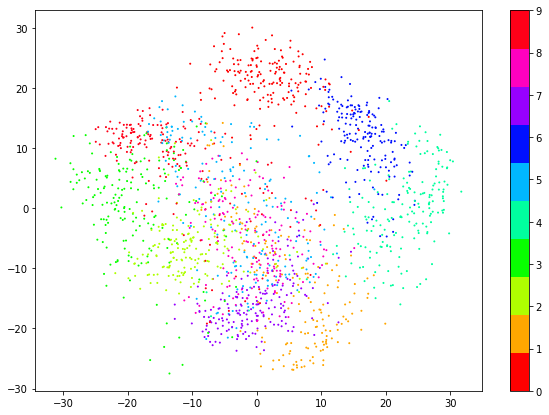

In [144]:
plt.figure(figsize=(10, 7))
plt.scatter(X_transformed[:, 0], X_transformed[:, 1], c=digits.target.astype(int), 
            cmap=plt.cm.get_cmap('hsv', 10), s=1)
plt.colorbar()
plt.show()

Разберем, что стоит за операцией transform. Это всего лишь операция проектирования в новый базис:

In [145]:
proj = np.dot(digits.data.astype(float) - pca.mean_, pca.components_.T)
proj.shape

(1797, 50)

И мы получаем ту же самую картинку:

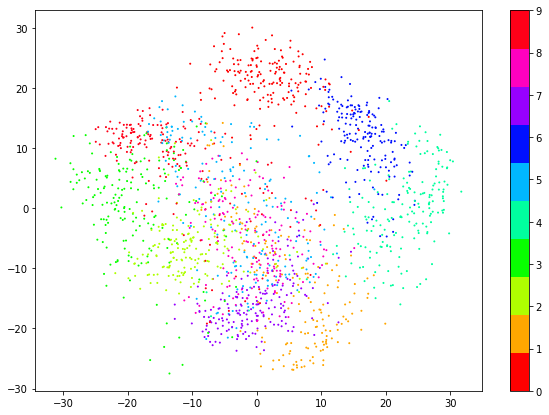

In [146]:
plt.figure(figsize=(10, 7))
plt.scatter(proj[:, 0], proj[:, 1], c=digits.target.astype(int), 
            cmap=plt.cm.get_cmap('hsv', 10), s=1)
plt.colorbar()
plt.show()

Картинка в 3D:

<IPython.core.display.Javascript object>


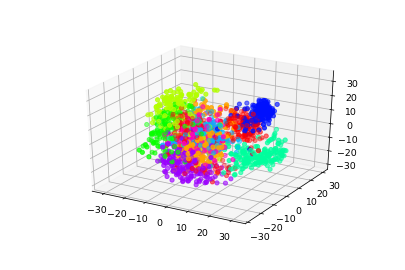

In [147]:
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(*X_transformed.T[:3], c=digits.target.astype(int), cmap='hsv')
plt.show()

Теперь выполним обратное преобразование:

In [148]:
X_restored = pca.inverse_transform(X_transformed)
X_restored.shape

(1797, 64)

Слева оригинал, справа - изображение, восстановленное из проекции

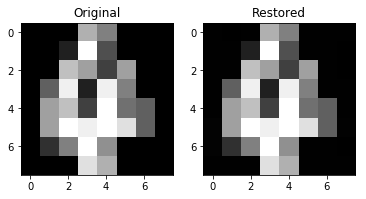

In [149]:
%matplotlib inline
i = 540
fig, ax = plt.subplots(1, 2)
ax[0].imshow(images[i], cmap='gray')
ax[1].imshow(X_restored[i].reshape(8, 8), cmap='gray')
ax[0].set_title('Original')
ax[1].set_title('Restored')
plt.show()

### Задача 1
Выпишите явное линейное преобразование, которое отображает точку из подространства главных компонент в исходное пространство (заполните ??? так, чтобы результат совпал с результатом в предыдущей ячейке)

Проделаем обратную операцию к тому, что происходит в строке In(145)

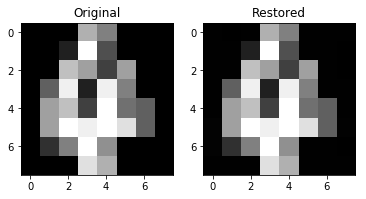

In [156]:
res = np.dot(X_transformed, pca.components_) + pca.mean_

i = 540
fig, ax = plt.subplots(1, 2)
ax[0].imshow(images[i], cmap='gray')
ax[1].imshow(res[i].reshape(8, 8), cmap='gray')
ax[0].set_title('Original')
ax[1].set_title('Restored')
plt.show()

Задача 2.

Определите, сколько нужно взять главных компонент, чтобы объяснить 99%, 95%, 90%, и 85% исходной дисперсии.

In [157]:
pca_99 = PCA(n_components=0.99, svd_solver='full')
pca_95 = PCA(n_components=0.95, svd_solver='full')
pca_90 = PCA(n_components=0.90, svd_solver='full')
pca_85 = PCA(n_components=0.85, svd_solver='full')

X_99 = pca_99.fit_transform(digits.data.astype(float))
X_95 = pca_95.fit_transform(digits.data.astype(float))
X_90 = pca_90.fit_transform(digits.data.astype(float))
X_85 = pca_85.fit_transform(digits.data.astype(float))

print ('Необходимое количество компонеент для 99,95,90 и 85 % соответственно:', pca_99.n_components_, pca_95.n_components_, pca_90.n_components_, pca_85.n_components_)

Необходимое количество компонеент для 99,95,90 и 85 % соответственно: 41 29 21 17


Задание 3.

Нарисуйте пример исходного изображения и результат восстановления из числа компонент, которое вы нашли в предыдущей задаче.

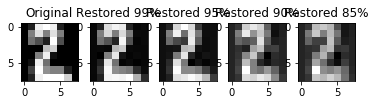

In [158]:
i = 333
fig, ax = plt.subplots(1, 5)

R_99 = pca_99.inverse_transform(X_99)

ax[0].imshow(images[i], cmap='gray')
ax[1].imshow(R_99[i].reshape(8, 8), cmap='gray')
ax[0].set_title('Original')
ax[1].set_title('Restored 99%')


R_95 = pca_95.inverse_transform(X_95)

ax[2].imshow(R_95[i].reshape(8, 8), cmap='gray')
ax[2].set_title('Restored 95%')

R_90 = pca_90.inverse_transform(X_90)

ax[3].imshow(R_90[i].reshape(8, 8), cmap='gray')
ax[3].set_title('Restored 90%')

R_85 = pca_85.inverse_transform(X_85)

ax[4].imshow(R_85[i].reshape(8, 8), cmap='gray')
ax[4].set_title('Restored 85%')
plt.show()

Задание 4.

Если бы я знал, что сюда придумать, то я бы знал, что сюда придумать...